In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
text_features_org = np.load("./text_features.npy", allow_pickle=True)
print(text_features_org.shape) # num_ids, 2
print(text_features_org[0].shape) # id, feature
print(text_features_org[0][1].shape) # feature_size
# text_emb_size = text_features[0][1].shape[0]
# text_features = {f[0]: f[1] for f in text_features}
text_emb_size = 32
text_features = {f[0]: np.random.rand(text_emb_size) for f in text_features_org}

(5040, 2)
(2,)
(29281,)


In [3]:
# Mocked Video Embeddings
video_emb_size = 32
video_features = {f[0]: np.random.rand(video_emb_size) for f in text_features_org}

In [4]:
warm_train = pd.read_csv("./warm_train.csv")
warm_val = pd.read_csv("./warm_val.csv")
warm_test = pd.read_csv("./warm_test.csv")
cold_val = pd.read_csv("./cold_val.csv")
cold_test = pd.read_csv("./cold_test.csv")
warm_train_items = warm_train["movielens_id"].unique()
warm_val_items = warm_val["movielens_id"].unique()
warm_test_items = warm_test["movielens_id"].unique()
cold_val_items = cold_val["movielens_id"].unique()
cold_test_items = cold_test["movielens_id"].unique()
all_items = np.concatenate([warm_train_items, warm_val_items, warm_test_items, cold_val_items, cold_test_items], axis=0)

In [5]:
# implicit feedback with rating
threshold = 3.5
ratings = pd.read_csv("./ratings_tv.csv")
ratings['rating'] = ratings['rating'].map(lambda x: 0 if x < threshold else 1)
ratings.rename(columns={"movielens_id": "item_id", "userId": "user_id"}, inplace=True)

In [6]:
# filter items if not in warm and cold
ratings = ratings[ratings["item_id"].isin(all_items)]

In [7]:
# append text features
text = []
for item_id in ratings["item_id"]:
    text.append(text_features[item_id])
ratings["text"] = text

In [8]:
# append video features
video = []
for item_id in ratings["item_id"]:
    video.append(video_features[item_id])
ratings["video"] = video

In [9]:
orders = ["user_id", "item_id", "text", "video", "rating"]
ratings = ratings[orders]
description = [
    ('user_id', 1 + np.max(ratings['user_id']), 'spr'),
    ('item_id', 1 + np.max(ratings['item_id']), 'spr'),
    ('text', text_emb_size, 'pretrained'),
    ('video', video_emb_size, 'pretrained'),
    ('rating', 2, 'label'),
    ('count', -1, 'ctn'),
]

In [10]:
ratings.head()

,user_id,item_id,text,video,rating
165998,1,112,"[0.438189518001735, 0.6370522229950104, 0.0086...","[0.04912376121610795, 0.8232656114469328, 0.87...",1
165999,19,112,"[0.438189518001735, 0.6370522229950104, 0.0086...","[0.04912376121610795, 0.8232656114469328, 0.87...",1
166000,24,112,"[0.438189518001735, 0.6370522229950104, 0.0086...","[0.04912376121610795, 0.8232656114469328, 0.87...",0
166001,29,112,"[0.438189518001735, 0.6370522229950104, 0.0086...","[0.04912376121610795, 0.8232656114469328, 0.87...",1
166002,39,112,"[0.438189518001735, 0.6370522229950104, 0.0086...","[0.04912376121610795, 0.8232656114469328, 0.87...",0


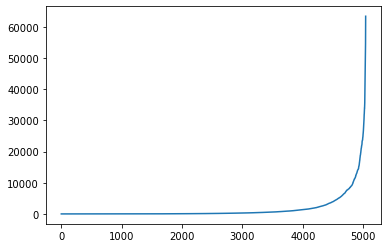

In [11]:
user2count = ratings.groupby(['item_id']).size().reset_index(name='count').sort_values(by='count')
item_ids = list(user2count['item_id'])
counts = np.array(user2count['count'])
plt.plot(np.arange(len(counts)), counts)

In [12]:
# Preprocess count
ratings = ratings.join(user2count.set_index('item_id'), on='item_id')
min_count = np.min(ratings['count'])
max_count = np.max(ratings['count'])
ratings['count'] = ratings['count'].map(lambda x: (x - min_count)/(max_count - min_count))

In [13]:
# warm/cold, train/test/val split is based on item id
warm_train = ratings[ratings["item_id"].isin(warm_train_items)]
warm_val = ratings[ratings["item_id"].isin(warm_val_items)]
warm_test = ratings[ratings["item_id"].isin(warm_test_items)]
cold_val = ratings[ratings["item_id"].isin(cold_val_items)]
cold_test = ratings[ratings["item_id"].isin(cold_test_items)]

assert set(warm_train["item_id"].unique()) == set(warm_train_items)
assert set(warm_val["item_id"].unique()) == set(warm_val_items)
assert set(warm_test["item_id"].unique()) == set(warm_test_items)
assert set(cold_val["item_id"].unique()) == set(cold_val_items)
assert set(cold_test["item_id"].unique()) == set(cold_test_items)

save_dic = {
    "warm_train": warm_train,
    "warm_val": warm_val,
    "warm_test": warm_test,
    "cold_val": cold_val,
    "cold_test": cold_test,
    "description": description,
}
for name, df in save_dic.items():
    print("{} size: {}".format(name, len(df)))
with open('./movielens_data.pkl', 'bw+') as f:
    pickle.dump(save_dic, f)

warm_train size: 4494776
warm_val size: 4476231
warm_test size: 4478135
cold_val size: 2165571
cold_test size: 1686937
description size: 6
